# Metal-Archives reviews - Part 1: Exploratory analysis

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
sns.set(font_scale=2)

In [2]:
def padded_array(x, pad):
    return np.concatenate((np.ones(pad) * x[0], x, np.ones(pad) * x[-1]))

def smooth(x, kernel, w, pad):
    kernel /= kernel.sum()
    x_smooth = np.convolve(x, kernel, mode='same')
    std = np.sqrt(np.convolve((x - x_smooth)**2, kernel, mode='same'))
    if pad > 0:
        x_smooth = x_smooth[pad:-pad]
    if pad > 0:
        std = std[pad:-pad]
    return x_smooth, std

def gsmooth(x, w=1, pad='auto', kernel_threshold=1e-5):
    if w == 0:
        return x, np.zeros_like(x)
    if pad == 'auto':
        pad = w
    x_padded = padded_array(x, pad)
    kernel_x = np.linspace(-x.size, x.size, x_padded.size)
    sigma = w / (2 * np.sqrt(2 * np.log(2)))
    kernel = np.exp(-kernel_x**2 / (2 * sigma**2))
    kernel[kernel < kernel_threshold] = 0
    return smooth(x_padded, kernel, w, pad)

In [3]:
df = pd.read_csv('reviews.csv')

### Basic statistics

In [4]:
print(f"average album review: {df.album_review_avg.mean():.1f}")
print(f"average number of reviews: {df.album_review_num.mean():.1f}")
print(f"highest number of reviews: {df.album_review_num.max():}")

average album review: 79.1
average number of reviews: 9.4
highest number of reviews: 40


### Most-reviewed album

In [5]:
df.iloc[df.album_review_num.idxmax()]

band_name                                                         Metallica
band_id                                                                 125
band_url                  https://www.metal-archives.com/bands/Metallica...
band_country_of_origin                                        United States
band_location                         Los Angeles/San Francisco, California
band_status                                                          Active
band_formed_in                                                         1981
band_genre                Thrash Metal (early); Hard Rock (mid); Heavy/T...
band_lyrical_themes       Corruption, Death, Life, Internal struggles, A...
band_last_label                                                         NaN
band_years_active                                           \n1981-present 
album_name                                                Master of Puppets
album_type                                                      Full-length
album_year  

Text(0, 0.5, 'Albums')

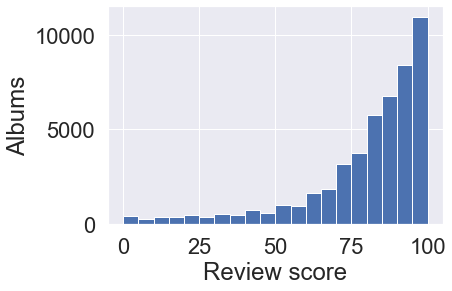

In [42]:
df.review_title.str.extract('(\d+)\%$').astype(int).hist(bins=20)
plt.title("")
plt.xlabel("Review score")
plt.ylabel("Albums")

# Weighted album score

I could analyze the quality of these albums by simply looking at average review ratings, but doing so fails to weigh in each album's popularity (or infamy). There are two reasons why this matters:
* There are countless albums on MA with only a single, 100% review. To say these albums are all better than Megadeth's "Rust in Peace" is disingenuous. Although I could apply a minimum number of reviews required, this shrinks down the dataset considerably. A weighted score should be distinguish good albums based on them having many positive reviews, not just a handful.
* Using a score weighted by the number of reviews would help emphasize the "badness" of albums that are notoriously bad. Take Metallica's infamous "St. Anger": to simply look at its average review of 45% doesn't take into account the gravity of its rating. The fact that 29 reviewers all agree that the album is a steaming pile of trash should be taken into account.

I define a weighted review score that I will hereonafter refer to simply as "score" (the individual/average review ratings will just be called "ratings"). To compute this, first the average review ratings are scaled to zero mean and unit variance, so it measures standard deviations from the mean review (~79%). The number of reviews is meanwhile normalized to the max number of reviews (40 reviews for Metallica's "Master of Puppets"). The score of an album is defined as the product of these two values, scaled to zero mean and unit variance. Thus, every review for an album that is above the global mean will increase the album's score, and every review below will decrease it. Albums with few reviews will stay near zero, even if those reviews are very positive or negative. Albums with many reviews could be anywhere on the spectrum based on the ratings.

In [6]:
df_albums = df[[col for col in df.columns if re.match('^(?!review)', col)]].groupby('album_name').first()
df_albums['album_score'] = (
    (df_albums.album_review_avg - df_albums.album_review_avg.mean()) / df_albums.album_review_avg.std() *
    df_albums.album_review_num / df_albums.album_review_num.max()
)

In [7]:
def process_genre(genre):
    # Find words (including hyphenated words) not in parentheses
    out = re.findall('[\w\-]+(?![^(]*\))', genre.lower())
    out = [s for s in out if s != 'metal']
    return out


album_genres = df_albums.band_genre.apply(process_genre)
genres = sorted(set(album_genres.sum()))
for genre in genres:
    df_albums['genre_' + genre] = album_genres.apply(lambda x: int(genre in x))

In [8]:
df_bands = df.groupby('band_name')[[col for col in df.columns if 'band_' in col]].max()
band_genres = df_bands.band_genre.apply(process_genre)
genres = sorted(set(band_genres.sum()))
for genre in genres:
    df_bands['genre_' + genre] = band_genres.apply(lambda x: int(genre in x))

In [52]:
df_albums.to_csv('reviews_album_scores.csv')
df_bands.to_csv('reviews_band_scores.csv')

# Weighted score distribution

Score does generally increase with average review, but is more spread out where there are more reviews. Most of the outliers are on the lower end; these are albums that attract more ridicule than most albums attract praise.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


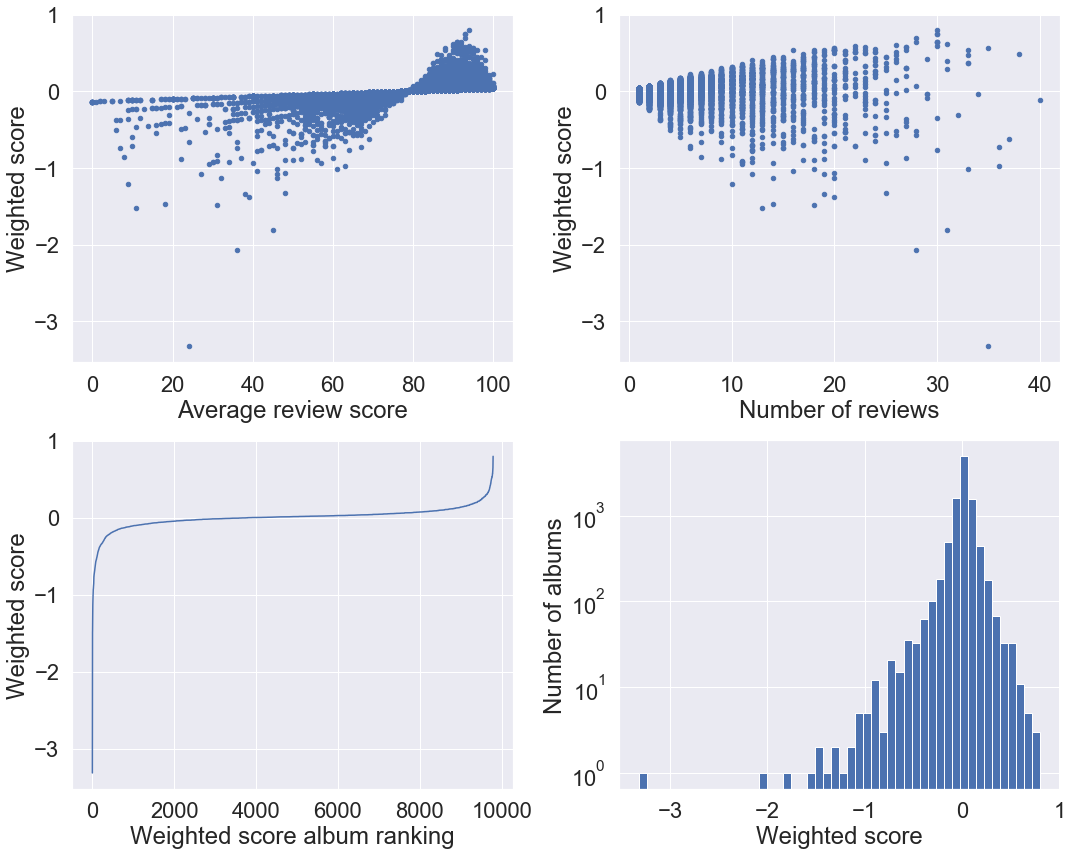

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

df_albums.plot('album_review_avg', 'album_score', 'scatter', ax=ax[0, 0])
ax[0, 0].set_xlabel("Average review score")
ax[0, 0].set_ylabel("Weighted score")

df_albums.plot('album_review_num', 'album_score', 'scatter', ax=ax[0, 1])
ax[0, 1].set_xlabel("Number of reviews")
ax[0, 1].set_ylabel("Weighted score")

df_albums.album_score.sort_values().reset_index(drop=True).plot(ax=ax[1, 0])
ax[1, 0].set_xlabel("Weighted score album ranking")
ax[1, 0].set_ylabel("Weighted score")

df_albums.album_score.hist(bins=50, ax=ax[1, 1])
ax[1, 1].set_xlabel("Weighted score")
ax[1, 1].set_ylabel("Number of albums")
ax[1, 1].set_yscale('log')

fig.tight_layout()

# Best and worst scoring albums

In [11]:
df_albums.sort_values('album_score', ascending=False)[['band_name', 'album_year', 'band_genre', 'album_score']][:20]

,band_name,album_year,band_genre,album_score
album_name,,,,
Ride the Lightning,Metallica,1984,Thrash Metal (early); Hard Rock (mid); Heavy/T...,0.798115
Symbolic,Death,1995,"Death Metal (early), Progressive Death Metal (...",0.746095
Paranoid,Black Sabbath,1970,Heavy/Doom Metal,0.746095
Beneath the Remains,Sepultura,1989,"Death/Thrash Metal (early), Nu-Metal, Groove/T...",0.696355
Powerslave,Iron Maiden,1984,"Heavy Metal, NWOBHM",0.647803
Altars of Madness,Morbid Angel,1989,Death Metal,0.642054
Storm of the Light's Bane,Dissection,1995,"Melodic Black Metal (early), Melodic Death Met...",0.642054
Hvis lyset tar oss,Burzum,1994,"Black Metal, Ambient",0.642054
Rust in Peace,Megadeth,1990,Speed/Thrash Metal (early/later); Heavy Metal/...,0.609702


In [12]:
df_albums.sort_values('album_score')[['band_name', 'album_year', 'band_genre', 'album_score']][:20]

,band_name,album_year,band_genre,album_score
album_name,,,,
Perverse Recollections of a Necromangler,Waking the Cadaver,2007,"Slam/Brutal Death Metal/Deathcore (early), Dea...",-3.317186
Illud Divinum Insanus,Morbid Angel,2011,Death Metal,-2.071122
St. Anger,Metallica,2003,Thrash Metal (early); Hard Rock (mid); Heavy/T...,-1.809240
Hellyeah,Hellyeah,2007,Groove Metal,-1.525145
The Unspoken King,Cryptopsy,2008,"Brutal/Technical Death Metal, Deathcore (2008)",-1.487496
Poser Holocaust,Thrash or Die,2011,Thrash Metal,-1.472531
Soundtrack to Your Escape,In Flames,2004,"Melodic Death Metal (early), Melodic Groove Me...",-1.375333
Decimate the Weak,Winds of Plague,2008,Symphonic Deathcore,-1.339512
God Hates Us All,Slayer,2001,Thrash Metal,-1.329014


# Best and worst scoring bands

To accumulate the highest total album score, a band must put out many albums, each garnering many positive reviews. Any below-average albums will drag a band's score down. Based on this metric, Death is the most consistently highly-reviewed metal band. Given their discography this is no surprise. These guys really didn't know how to put out a bad album. Their lowest reviewed full-length record, "The Sound of Perseverance" averaged just 1% below the 79% global average, while the rest sit above 81%. Black Sabbath can't boast the same consistency, with their later albums pulling down their score, but they still do well thanks to their first six albums that all averaged above 87%. Rush on the other hand earn their third place spot with an unbelievably steady discography of nineteen albums, most averaging above 80%.

The second table shows the downfall of many giants of the 80's whose early successes were overwhelmed by their poor later albums.

In [13]:
band_scores = df_albums.groupby('band_name').sum()[['album_score']]
band_scores['band_genre'] = df_albums.groupby('band_name')['band_genre'].first()

In [14]:
band_scores.sort_values('album_score', ascending=False)[['band_genre', 'album_score']][:20]

,band_genre,album_score
band_name,,
Death,"Death Metal (early), Progressive Death Metal (...",2.476521
Black Sabbath,Heavy/Doom Metal,2.103661
Rush,Hard Rock/Heavy Metal (early); Progressive Roc...,2.072685
Blind Guardian,"Speed Metal (early), Power Metal (later)",2.020260
Candlemass,Epic Doom Metal,1.762308
Bathory,"Black/Viking Metal, Thrash Metal",1.676003
Bolt Thrower,Death Metal,1.671734
Angra,Power/Progressive Metal,1.649673
Immolation,Death Metal,1.610667


In [15]:
band_scores.sort_values('album_score')[['band_genre', 'album_score']][:20]

,band_genre,album_score
band_name,,
In Flames,"Melodic Death Metal (early), Melodic Groove Me...",-5.685814
Six Feet Under,"Death/Groove Metal, Death 'n' Roll",-5.291732
Machine Head,"Groove/Thrash Metal, Nu-Metal",-3.884076
Waking the Cadaver,"Slam/Brutal Death Metal/Deathcore (early), Dea...",-3.869553
Queensrÿche,Heavy/Power/Progressive Metal,-3.759161
Metallica,Thrash Metal (early); Hard Rock (mid); Heavy/T...,-3.368888
Dimmu Borgir,Symphonic Black Metal,-3.352885
Whitechapel,Deathcore,-2.955307
Annihilator,Technical Speed/Thrash Metal (early); Groove/T...,-2.826623


# Best and worst scoring genres

Doom metal tops the chart of total album score, followed closely by black and progressive metal. At the bottom, groove metal, metalcore, and deathcore are perhaps to no one's surprise the lowest-scoring genres on MA.

In [16]:
genre_data = []
for genre in genres:
    df_genre = df_albums[df_albums['genre_' + genre] > 0]
    x = (genre, df_genre.shape[0], df_genre.album_score.sum())
    genre_data.append(x)
genre_ratings = pd.DataFrame(genre_data, columns=['genre', 'albums', 'score']).sort_values('score', ascending=False)

In [17]:
genre_ratings.sort_values('score', ascending=False)[:10]

,genre,albums,score
24,doom,1016,36.514884
8,black,2571,34.333908
77,progressive,997,29.797368
19,death,2798,12.764067
36,folk,495,12.579537
6,atmospheric,257,9.691863
7,avant-garde,183,8.874214
33,epic,204,7.390365
49,heavy,1522,7.081334
103,viking,175,6.931193


In [18]:
genre_ratings.sort_values('score')[:10]

,genre,albums,score
45,groove,405,-37.927245
57,metalcore,201,-19.739222
20,deathcore,112,-17.783023
2,alternative,97,-11.171870
56,melodic,934,-10.827943
98,thrash,1521,-9.387130
84,rock,916,-8.798607
64,nu-metal,55,-8.107471
94,symphonic,452,-7.599516
88,slam,35,-5.314407


### Best and worse countries

In [19]:
country_scores = df_albums.groupby('band_country_of_origin')['album_score'].sum()

In [20]:
country_scores.sort_values(ascending=False)[:10]

band_country_of_origin
United Kingdom    14.894496
Germany            9.360232
Sweden             7.635217
Denmark            6.579718
Norway             5.632707
Japan              4.198812
Greece             3.386373
Poland             3.170770
Ireland            2.237416
Australia          2.184441
Name: album_score, dtype: float64

In [21]:
country_scores.sort_values()[:10]

band_country_of_origin
United States   -32.381794
Italy            -3.452897
Philippines      -0.358063
International    -0.315270
Finland          -0.232394
Spain            -0.223047
Pakistan         -0.217797
Botswana         -0.178462
Belarus          -0.147796
Unknown          -0.127346
Name: album_score, dtype: float64

# Geographic distribution of bands, albums, and genres

Text(0.5, 1.0, 'Number of bands from each country')

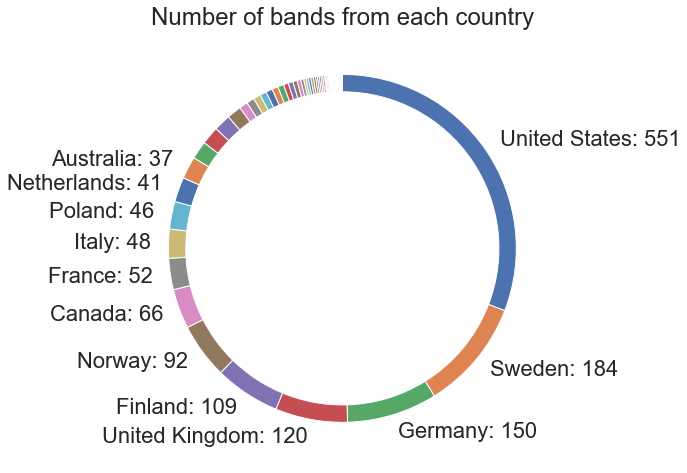

In [22]:
countries_num_bands = df_bands.groupby('band_country_of_origin').apply(len).sort_values(ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pie(
    countries_num_bands.values,
    labels=[('{}: {}'.format(country, num_bands) if num_bands > 0.02 * countries_num_bands.sum() else '')
            for country, num_bands in countries_num_bands.items()],
    wedgeprops=dict(width=0.1),
    startangle=90,
    counterclock=False
)
ax.set_aspect('equal')
ax.set_title('Number of bands from each country')

Text(0.5, 1.0, 'Number of albums from each country')

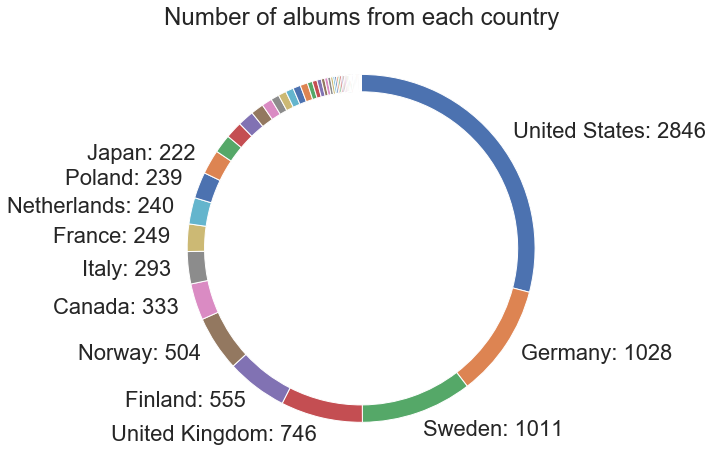

In [23]:
countries_num_albums = df_albums.groupby('band_country_of_origin').apply(len).sort_values(ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pie(
    countries_num_albums.values,
    labels=[('{}: {}'.format(country, num_albums) if num_albums > 0.02 * countries_num_albums.sum() else '')
            for country, num_albums in countries_num_albums.items()],
    wedgeprops=dict(width=0.1),
    startangle=90,
    counterclock=False
)
ax.set_aspect('equal')
ax.set_title('Number of albums from each country')

Text(0.5, 1.0, 'Number of albums from each U.S. state')

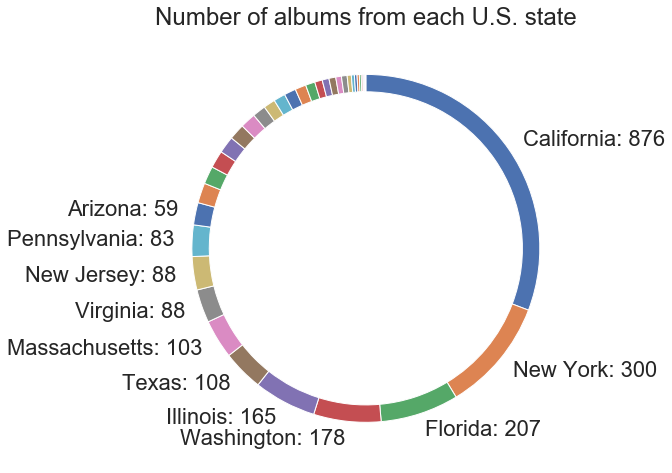

In [24]:
states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii',
    'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
    'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
    'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
    'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
]
df_usa = df_albums[df_albums.band_country_of_origin == 'United States'].copy()
pattern = '(' + '|'.join(states) + ')'
df_usa['state'] = df_usa.band_location.str.extract(pattern)
states_num_albums = df_usa.groupby('state').apply(len).sort_values(ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pie(
    states_num_albums.values,
    labels=[('{}: {}'.format(state, num_albums) if num_albums > 0.02 * states_num_albums.sum() else '')
            for state, num_albums in states_num_albums.items()],
    wedgeprops=dict(width=0.1),
    startangle=90,
    counterclock=False
)
ax.set_aspect('equal')
ax.set_title('Number of albums from each U.S. state')

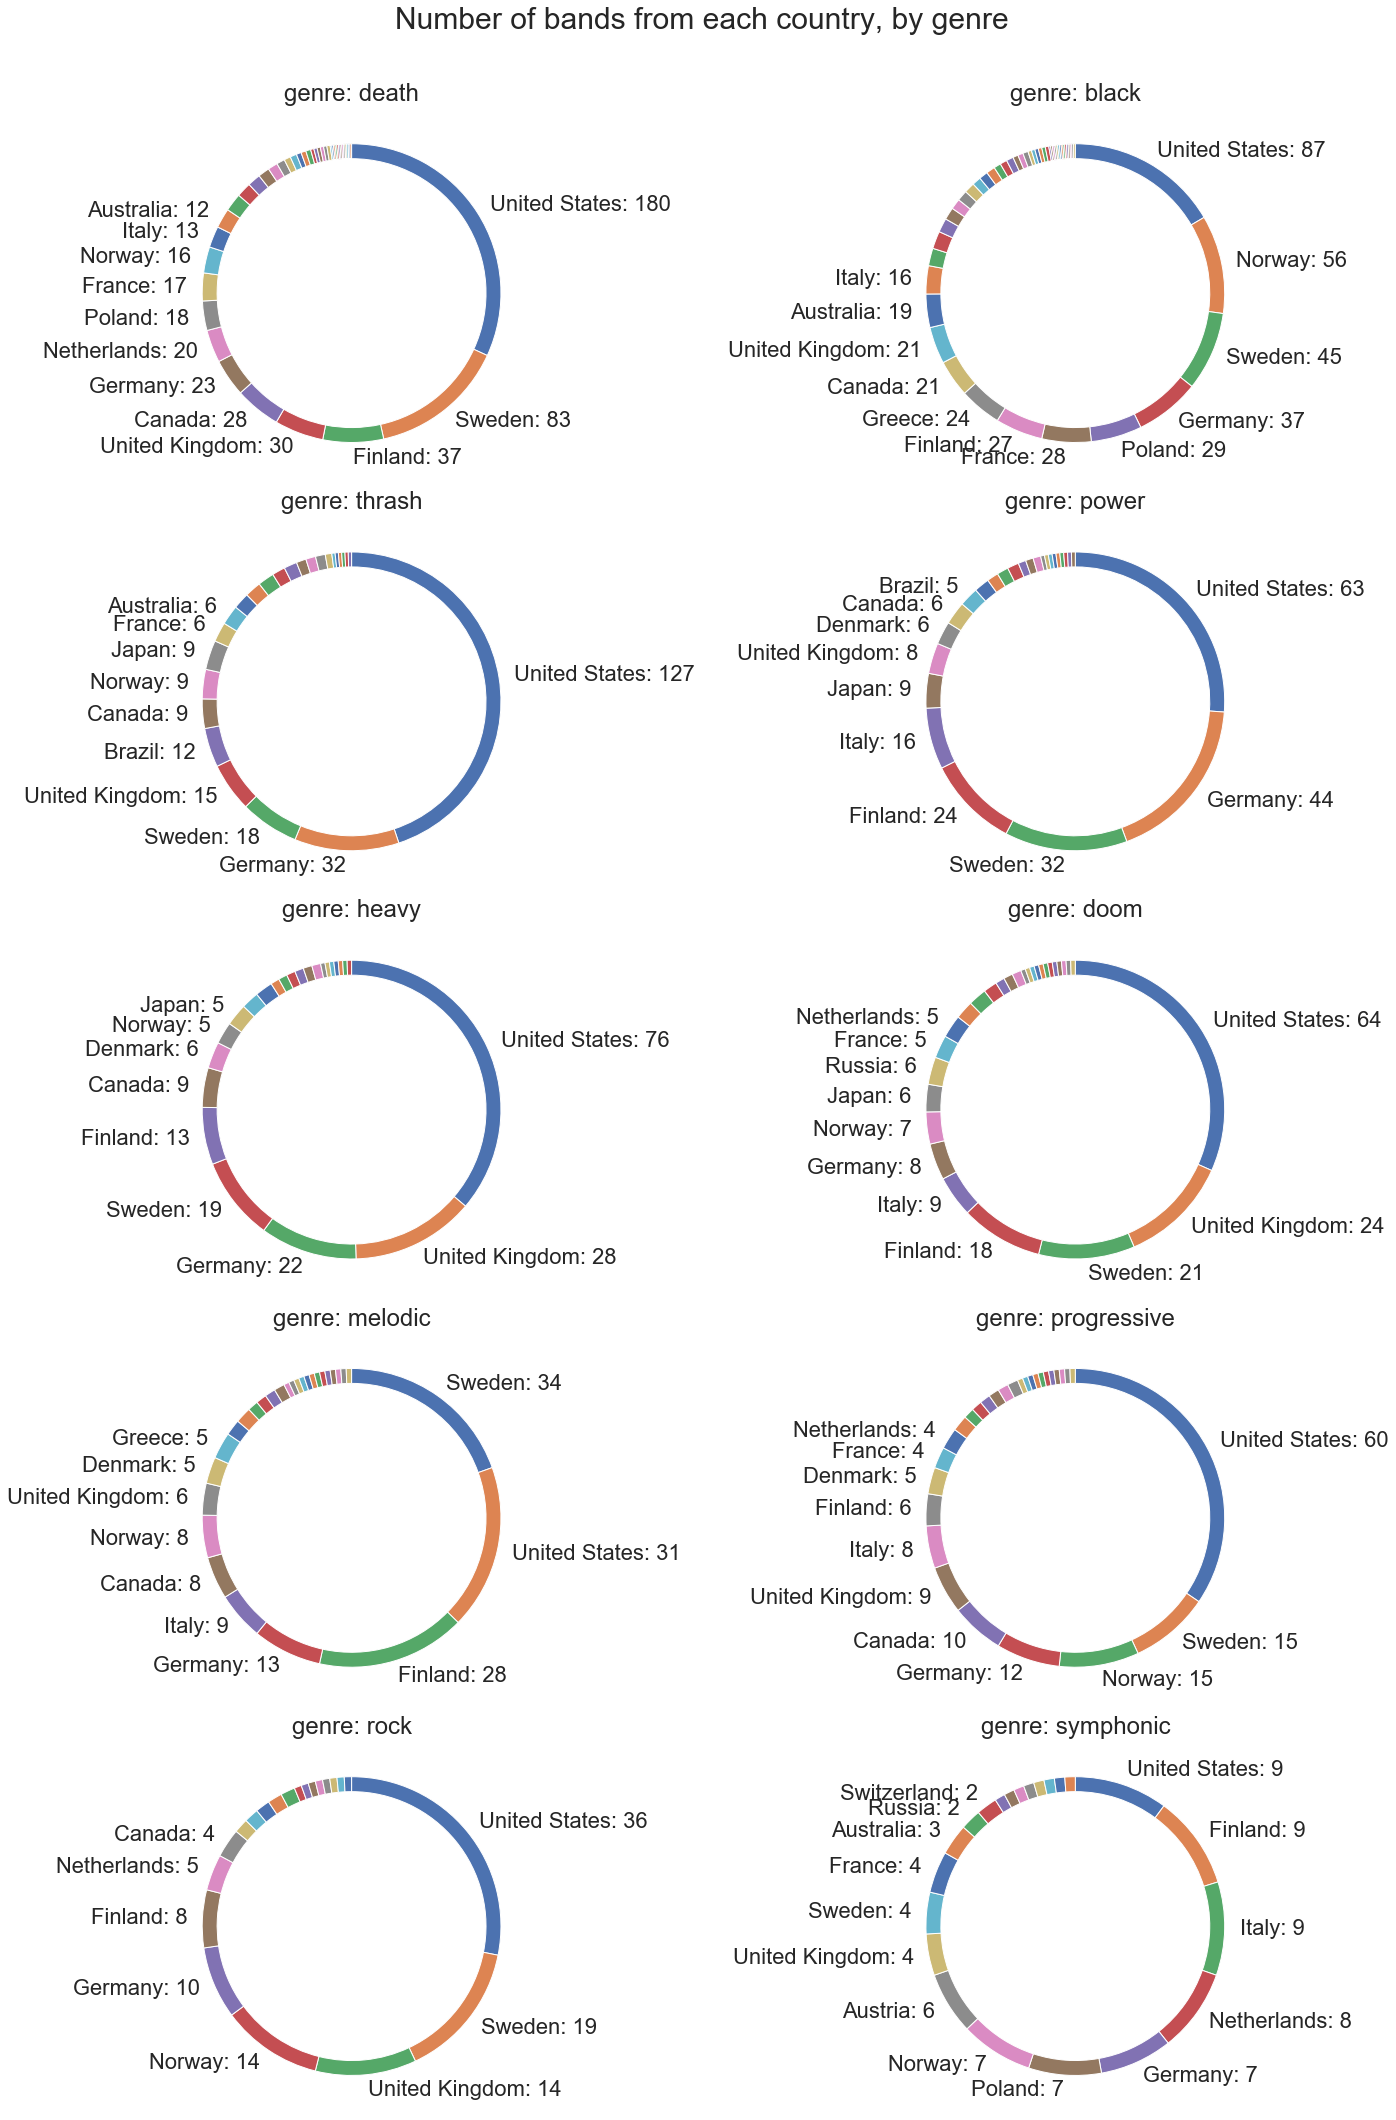

In [25]:
genres_num_bands = df_bands[[col for col in df_bands.columns if 'genre_' in col]].sum(0).sort_values(ascending=False)[:10]
fig, ax = plt.subplots(5, 2, figsize=(20, 30))
fig.suptitle("Number of bands from each country, by genre", fontsize=30)
ax = ax.flatten()
for i, col in enumerate(genres_num_bands.index):
    countries_genre_num_bands = df_bands[df_bands[col] > 0].groupby('band_country_of_origin').apply(len).sort_values(ascending=False)
    ax[i].pie(
        countries_genre_num_bands.values,
        labels=[('{}: {}'.format(country, num_bands) if num_bands > 0.02 * countries_genre_num_bands.sum() else '')
                for country, num_bands in countries_genre_num_bands.items()],
        wedgeprops=dict(width=0.1),
        startangle=90,
        counterclock=False
    )
    ax[i].set_aspect('equal')
    ax[i].set_title(f'genre: {col[6:]}')
fig.tight_layout(rect=[0, 0, 1, 0.95])

In [68]:
top_genres = ['black', 'death', 'thrash']
for country in countries:
    print(country)
    print(
        pd.Series({
            genre: df_bands[df_bands['band_country_of_origin'] == country]['genre_' + genre].sum()
            for genre in top_genres
        })
    )

Australia
black     19
death     12
thrash     6
dtype: int64
Brazil
black      8
death     11
thrash    12
dtype: int64
Canada
black     21
death     28
thrash     9
dtype: int64
Denmark
black     6
death     8
thrash    4
dtype: int64
Finland
black     27
death     37
thrash     5
dtype: int64
France
black     28
death     17
thrash     6
dtype: int64
Germany
black     37
death     23
thrash    32
dtype: int64
Greece
black     24
death      9
thrash     4
dtype: int64
Italy
black     16
death     13
thrash     5
dtype: int64
Japan
black     6
death     5
thrash    9
dtype: int64
Netherlands
black     10
death     20
thrash     5
dtype: int64
Norway
black     56
death     16
thrash     9
dtype: int64
Poland
black     29
death     18
thrash     3
dtype: int64
Sweden
black     45
death     83
thrash    18
dtype: int64
United Kingdom
black     21
death     30
thrash    15
dtype: int64
United States
black      87
death     180
thrash    127
dtype: int64


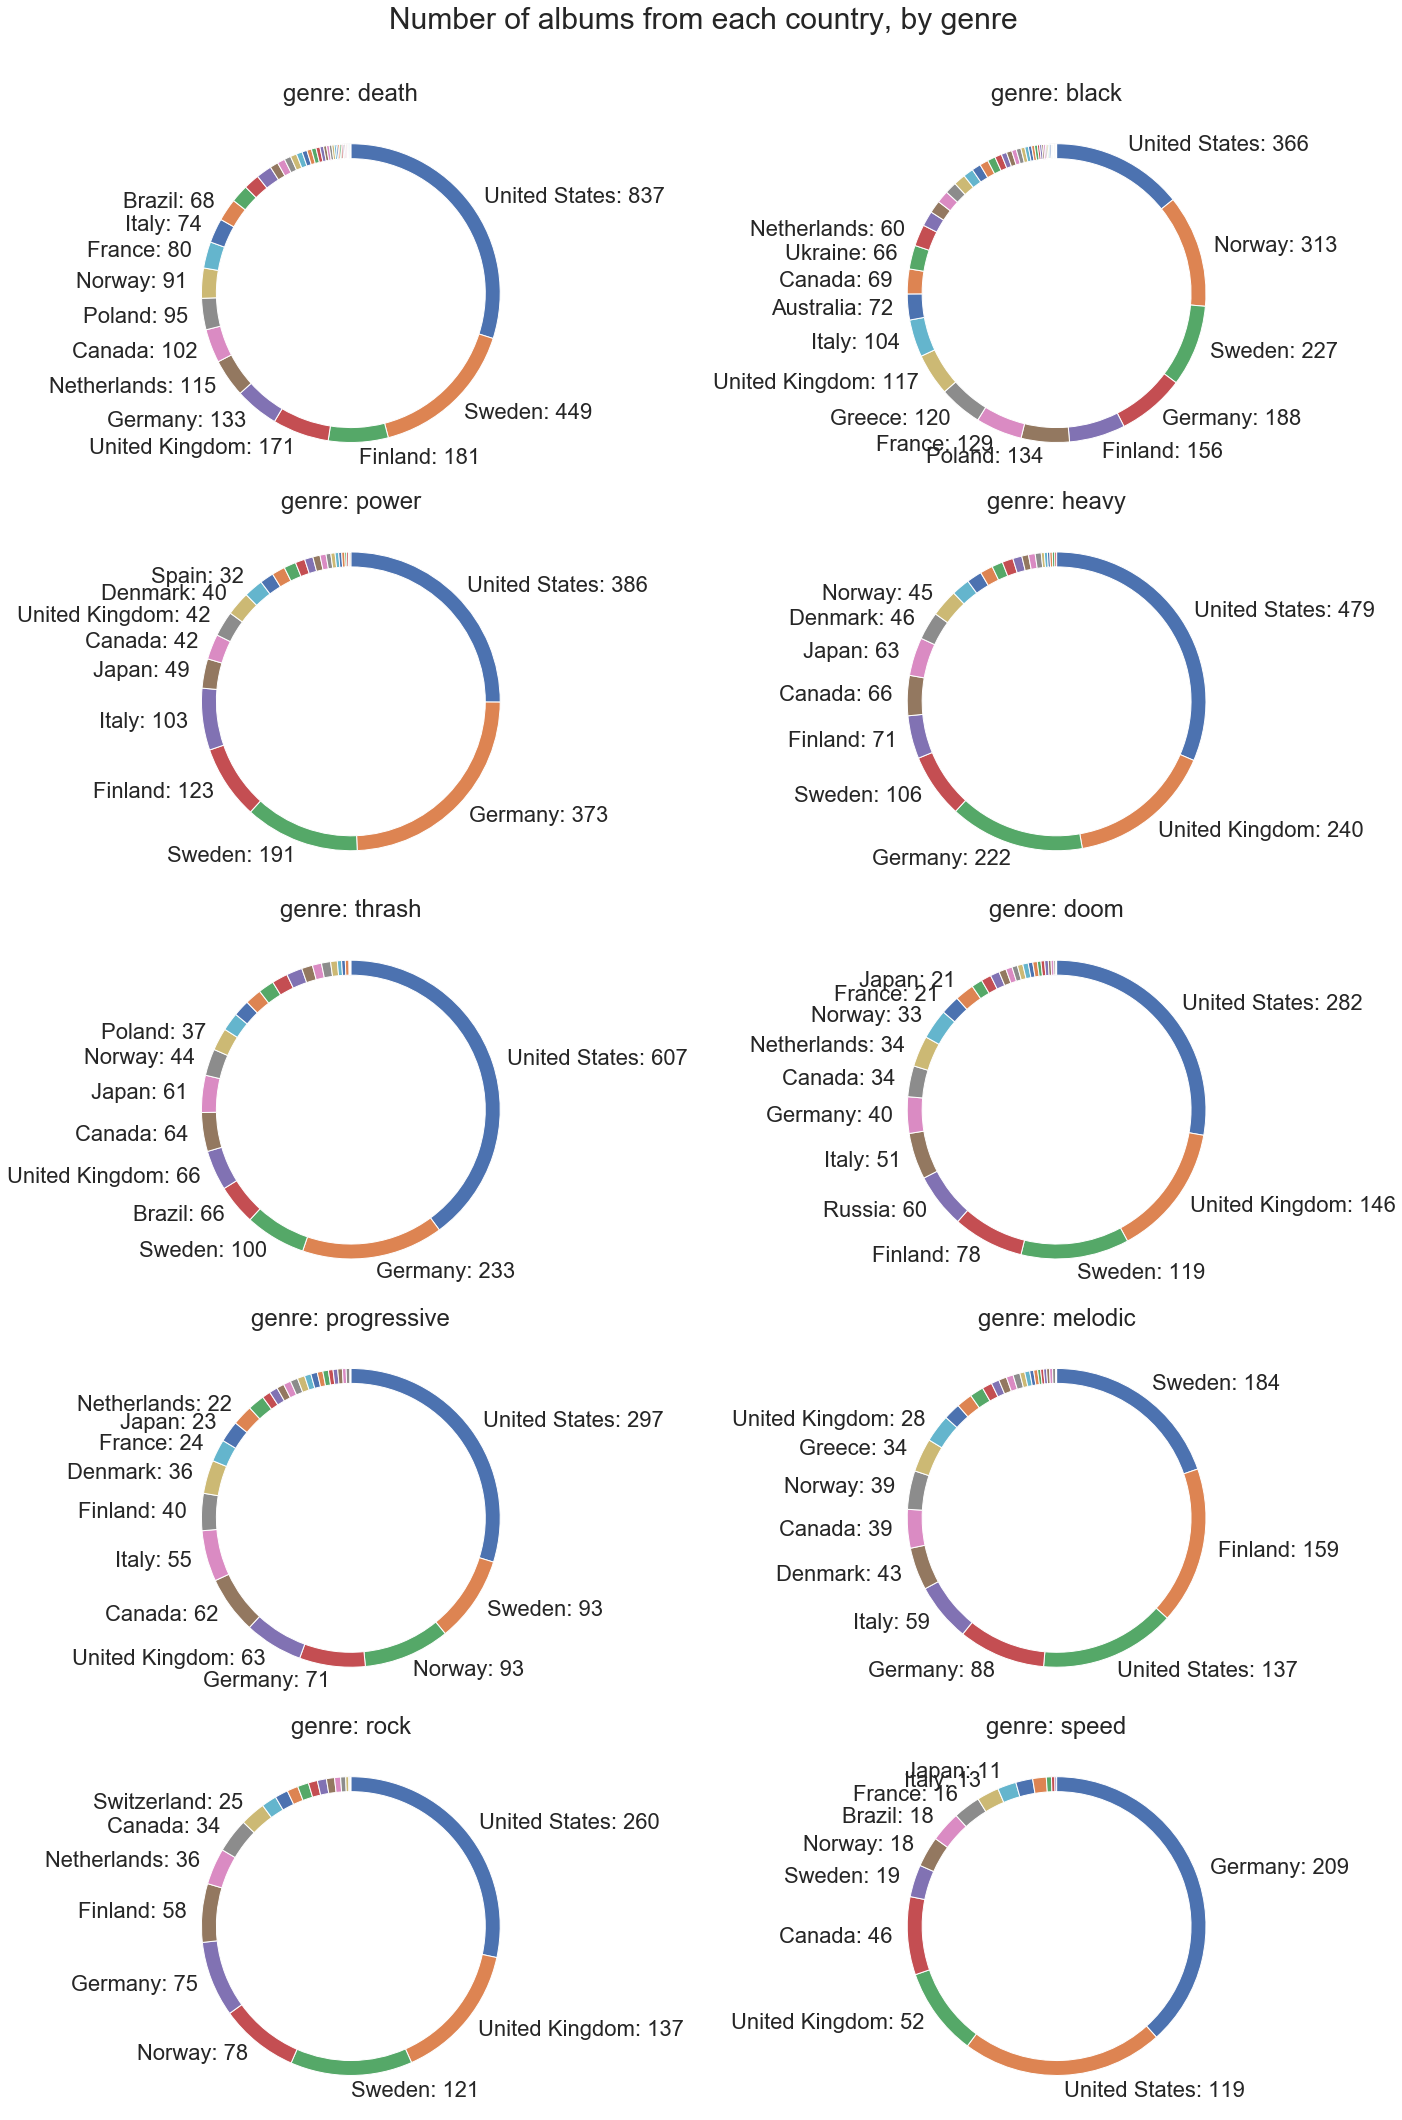

In [26]:
genres_num_albums = df_albums[[col for col in df_albums.columns if 'genre_' in col]].sum(0).sort_values(ascending=False)[:10]
fig, ax = plt.subplots(5, 2, figsize=(20, 30))
fig.suptitle("Number of albums from each country, by genre", fontsize=30)
ax = ax.flatten()
for i, col in enumerate(genres_num_albums.index):
    countries_genre_num_albums = df_albums[df_albums[col] > 0].groupby('band_country_of_origin').apply(len).sort_values(ascending=False)
    ax[i].pie(
        countries_genre_num_albums.values,
        labels=[('{}: {}'.format(country, num_albums) if num_albums > 0.02 * countries_genre_num_albums.sum() else '')
                for country, num_albums in countries_genre_num_albums.items()],
        wedgeprops=dict(width=0.1),
        startangle=90,
        counterclock=False
    )
    ax[i].set_aspect('equal')
    ax[i].set_title(f'genre: {col[6:]}')
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Decline of top-rated bands

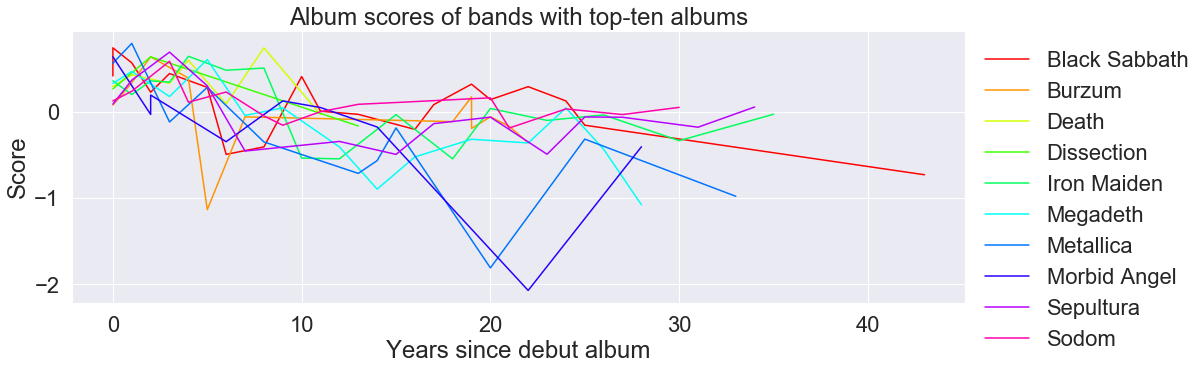

In [27]:
min_score = df_albums.album_score.sort_values(ascending=False)[10]
bands = sorted(set(df_albums.band_name))
band_scores = {}
for band in bands:
    df_band = df_albums[df_albums.band_name == band].sort_values('album_year')
    if df_band.album_score.max() >= min_score and df_band.shape[0] > 1:
        band_scores[band] = (df_band.album_year.values, df_band.album_score.values)
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
cmap = plt.cm.hsv
ax.set_prop_cycle(color=[cmap(i) for i in np.linspace(0, 0.9, len(band_scores))])
for band, (years, scores) in band_scores.items():
    ax.plot(years - years.min(), scores, label=band)
ax.set_title('Album scores of bands with top-ten albums')
ax.set_xlabel('Years since debut album')
ax.set_ylabel('Score')
ax.legend(bbox_to_anchor=(1, 1))

# Global album trends

Now for a more comprehensive look. We can see that the number of metal albums grew up until the late 2000's, and has been in sharp decline since. The average score suggests that 1970 was by far the most highly-rated year in metal history, but this is skewed by the fact that there were just four albums that early on, all of which have high scores (including Black Sabbath's first two albums). It's better to sum up the scores from each year than to average them, in order to weigh in the number of albums released that year. Doing so shows that the overall quality of metal albums peaked towards the end of the 80s, not surprisingly the same time that many of those top bands from above were releasing their most iconic albums. As the metal scene saturated, the quality dropped, hitting a low point that coincides with the peak in number of albums.

An alternative explanation could be that nostalgia inflates reviewers' opinions of earlier albums, especially in those bands above whose quality floundered over the years. There's little that can be done to test this hypothesis since all of the reviews of early albums here are written with hindsight.

There is likely also a selection bias that is picked up by the popularity-weighted score, since classic albums are more popular than equally high-quality albums today.

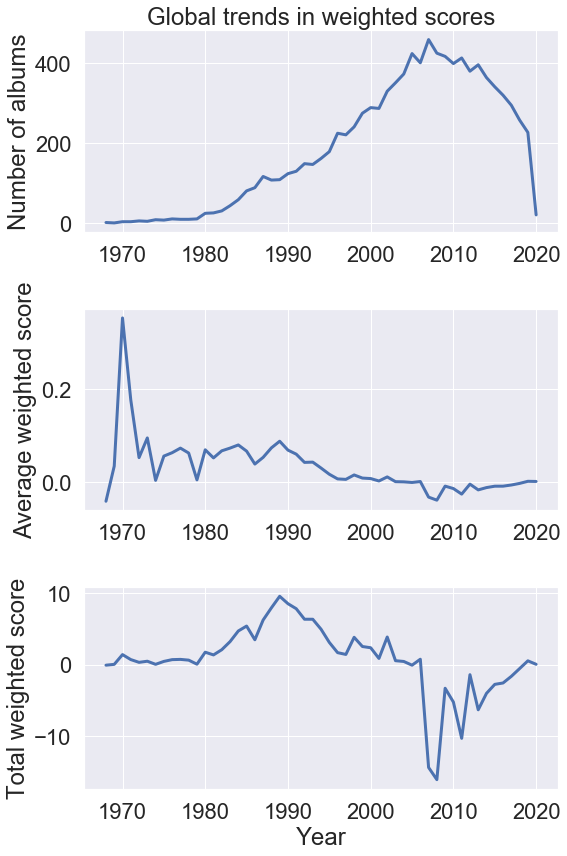

In [28]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
df_albums.groupby('album_year').size().plot(lw=3, ax=ax[0])
df_albums.groupby('album_year')['album_score'].mean().plot(lw=3, ax=ax[1])
df_albums.groupby('album_year')['album_score'].sum().plot(lw=3, ax=ax[2])
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('Year')
ax[0].set_ylabel('Number of albums')
ax[1].set_ylabel('Average weighted score')
ax[2].set_ylabel('Total weighted score')
ax[0].set_title('Global trends in weighted scores')
fig.tight_layout()
plt.show()

# Genre trends

## Yearly album output

Although most genres contributed to the rise of metal in the 2000s, black and death metal dominate the trend. Heavy and thrash metal dominated the scene before them, spearheading the 80s upswing.

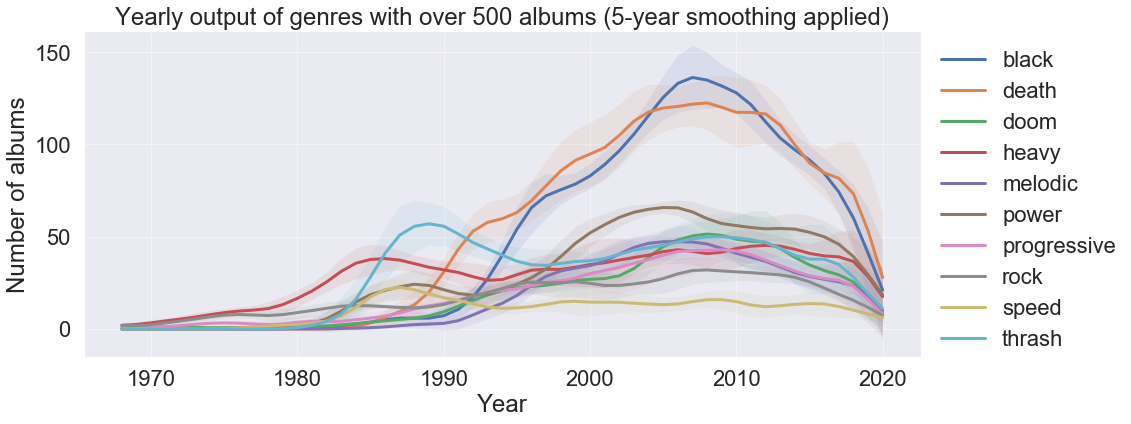

In [29]:
min_albums = 500
smoothing = 5
genre_years = df_albums.groupby('album_year')[df_albums.columns[df_albums.columns.str.contains('genre_')]].sum()
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
for i, col in genre_years.iteritems():
    if col.sum() > min_albums:
        x = col.index
        y, y_std = gsmooth(col.values, smoothing)
        plt.plot(x, y, lw=3, label=i.replace('genre_', ''))
        plt.fill_between(x, y - 2 * y_std, y + 2 * y_std, alpha=0.1)
ax.set_xlabel('Year')
ax.set_ylabel('Number of albums')
if smoothing > 0:
    title = 'Yearly output of genres with over {} albums ({}-year smoothing applied)'.format(min_albums, smoothing)
else:
    title = 'Yearly output of genres with over {} albums'.format(min_albums)
ax.set_title(title)
ax.legend(bbox_to_anchor=(1, 1))
ax.grid(alpha=0.5)

## Yearly average album score

The average score of all albums in a genre should tend toward zero; instead we see both genre-specific and global trends in score averages beolow. Early doom metal (led by Black Sabbath) is very highly rated but has converged towards zero since then. Early black metal likewise had a high-scoring start followed by gradual decline. The overall trend among genres drops below zero during the time when most metal albums were being recorded, more evidence of a saturation in the heavy metal market.

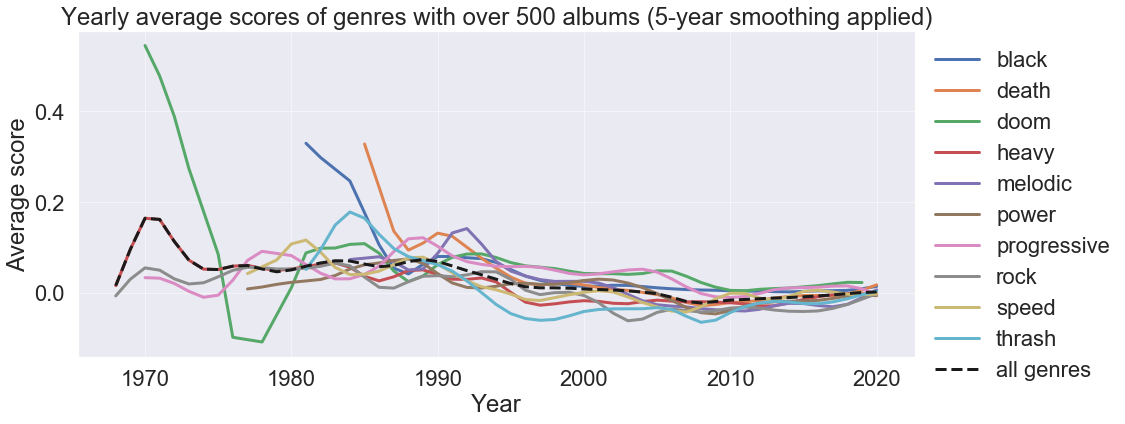

In [30]:
min_albums = 500
smoothing = 5
fig, ax = plt.subplots(1, 1, figsize=(15,6))
for genre in genres:
    df_genre = df_albums[df_albums['genre_' + genre] > 0][['album_year', 'album_score']].sort_values('album_year').reset_index(drop=True)
    if len(df_genre) > min_albums:
        series = df_genre.groupby('album_year').album_score.mean()
        x = series.index
        y, y_std = gsmooth(series.values, smoothing)
        plt.plot(x, y, lw=3, label=genre.replace('genre_', ''))
avg = df_albums.groupby('album_year').album_score.mean()
x = avg.index
y, y_std = gsmooth(avg.values, smoothing)
ax.plot(x, y, 'k--', lw=3, label='all genres')
ax.set_xlabel('Year')
ax.set_ylabel('Average score')
if smoothing > 0:
    title = 'Yearly average scores of genres with over {} albums ({}-year smoothing applied)'.format(min_albums, smoothing)
else:
    title = 'Yearly average scores of genres with over {} albums'.format(min_albums)
ax.set_title(title)
ax.legend(bbox_to_anchor=(1, 1))
ax.grid(alpha=0.5)

## Yearly total album score

The total score trends shows a peak in quality and quantity right at the end of the 80s, and a more egregious indication of a saturation in the late 2000s.

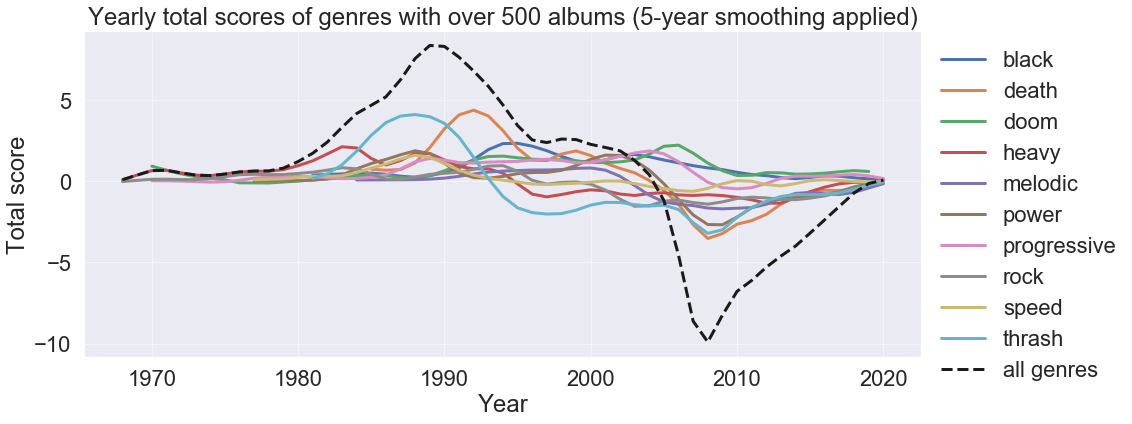

In [31]:
min_albums = 500
smoothing = 5
fig, ax = plt.subplots(1, 1, figsize=(15,6))
for genre in genres:
    df_genre = df_albums[df_albums['genre_' + genre] > 0][['album_year', 'album_score']].sort_values('album_year').reset_index(drop=True)
    if len(df_genre) > min_albums:
        series = df_genre.groupby('album_year').album_score.sum()
        x = series.index
        y, y_std = gsmooth(series.values, smoothing)
        plt.plot(x, y, lw=3, label=genre.replace('genre_', ''))
avg = df_albums.groupby('album_year').album_score.sum()
x = avg.index
y, y_std = gsmooth(avg.values, smoothing)
ax.plot(x, y, 'k--', lw=3, label='all genres')
ax.set_xlabel('Year')
ax.set_ylabel('Total score')
if smoothing > 0:
    title = 'Yearly total scores of genres with over {} albums ({}-year smoothing applied)'.format(min_albums, smoothing)
else:
    title = 'Yearly total scores of genres with over {} albums'.format(min_albums)
ax.set_title(title)
ax.legend(bbox_to_anchor=(1, 1))
ax.grid(alpha=0.5)

# Geographic trends

These plots show just how consistently American bands have dominated the metal scence over the decades. The U.K. was the first nation to pull ahead of others in producing metal albums, but with the rise of the thrash era in the late 80s, the U.S.A. took the lead and never lost it, despite the Scandinavian black/death metal scene pulling some attention away from the American thrash brand.

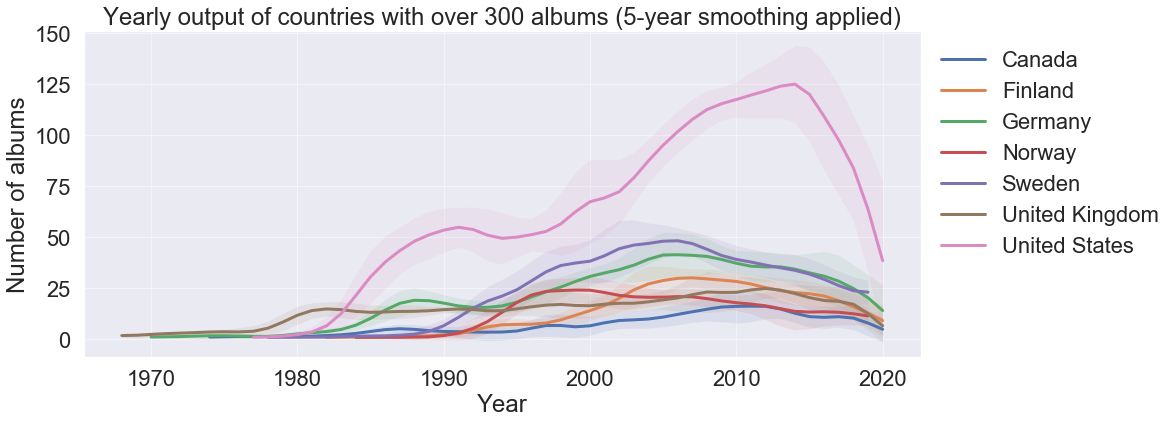

In [32]:
min_albums = 300
smoothing = 5
countries_albums = df_albums.groupby('band_country_of_origin').size()
countries = countries_albums[countries_albums > min_albums]
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
for country in countries.index:
    df_country = df_albums[df_albums['band_country_of_origin'] == country]
    series = df_country.groupby('album_year').size()
    x = series.index
    y, y_std = gsmooth(series.values, smoothing)
    ax.plot(x, y, lw=3, label=country)
    ax.fill_between(x, y - 2 * y_std, y + 2 * y_std, alpha=0.1)
ax.set_xlabel('Year')
ax.set_ylabel('Number of albums')
if smoothing > 0:
    title = 'Yearly output of countries with over {} albums ({}-year smoothing applied)'.format(min_albums, smoothing)
else:
    title = 'Yearly output of countries with over {} albums'.format(min_albums)
ax.set_title(title)
ax.legend(bbox_to_anchor=(1, 1))
ax.grid(alpha=0.5)

The plot below provides more clarity to the changes seen so far. With each bump in national average scores comes a new shift between genres; the U.K.-to-U.S.A. transition marks the rise of thrash, the U.S.A. gives way in the mid 80s to Swedish death metal, and Sweden hands the baton to Norwegian black metal in the 90s. Sadly no nation was up to the task of ushering forth a new frontier in metal when the Norwegian scene entered its decline.

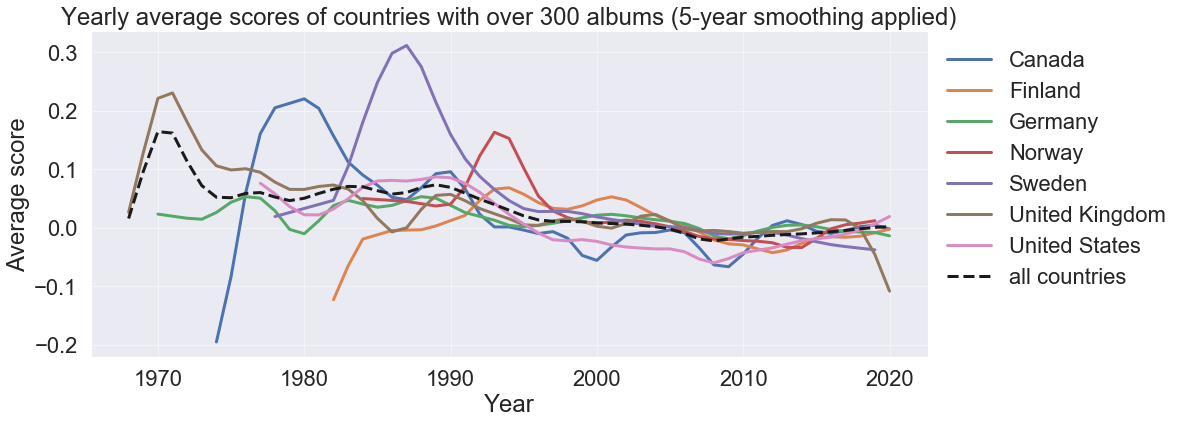

In [33]:
min_albums = 300
smoothing = 5
countries_albums = df_albums.groupby('band_country_of_origin').size()
countries = countries_albums[countries_albums > min_albums]
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
for country in countries.index:
    df = df_albums[df_albums['band_country_of_origin'] == country]
    series = df.groupby('album_year').album_score.mean()
    x = series.index
    y, y_std = gsmooth(series.values, smoothing)
    ax.plot(x, y, lw=3, label=country)
avg = df_albums.groupby('album_year').album_score.mean()
x = avg.index
y, y_std = gsmooth(avg.values, smoothing)
ax.plot(x, y, 'k--', lw=3, label='all countries')
ax.set_xlabel('Year')
ax.set_ylabel('Average score')
if smoothing > 0:
    title = 'Yearly average scores of countries with over {} albums ({}-year smoothing applied)'.format(min_albums, smoothing)
else:
    title = 'Yearly average scores of countries with over {} albums'.format(min_albums)
ax.set_title(title)
ax.legend(bbox_to_anchor=(1, 1))
ax.grid(alpha=0.5)

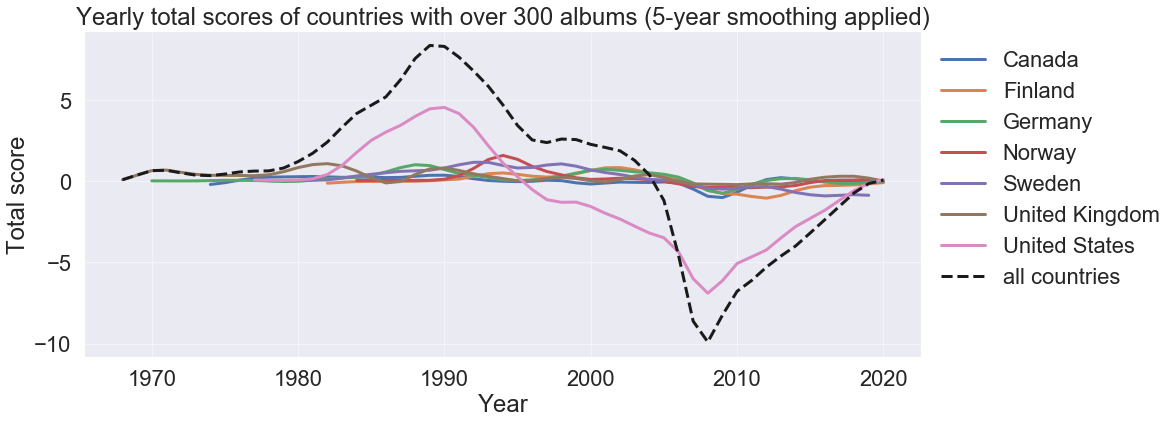

In [34]:
min_albums = 300
smoothing = 5
countries_albums = df_albums.groupby('band_country_of_origin').size()
countries = countries_albums[countries_albums > min_albums]
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
for country in countries.index:
    df = df_albums[df_albums['band_country_of_origin'] == country]
    series = df.groupby('album_year').album_score.sum()
    x = series.index
    y, y_std = gsmooth(series.values, smoothing)
    ax.plot(x, y, lw=3, label=country)
avg = df_albums.groupby('album_year').album_score.sum()
x = avg.index
y, y_std = gsmooth(avg.values, smoothing)
ax.plot(x, y, 'k--', lw=3, label='all countries')
ax.set_xlabel('Year')
ax.set_ylabel('Total score')
if smoothing > 0:
    title = 'Yearly total scores of countries with over {} albums ({}-year smoothing applied)'.format(min_albums, smoothing)
else:
    title = 'Yearly total scores of countries with over {} albums'.format(min_albums)
ax.set_title(title)
ax.legend(bbox_to_anchor=(1, 1))
ax.grid(alpha=0.5)

# Top-ten genres in each country

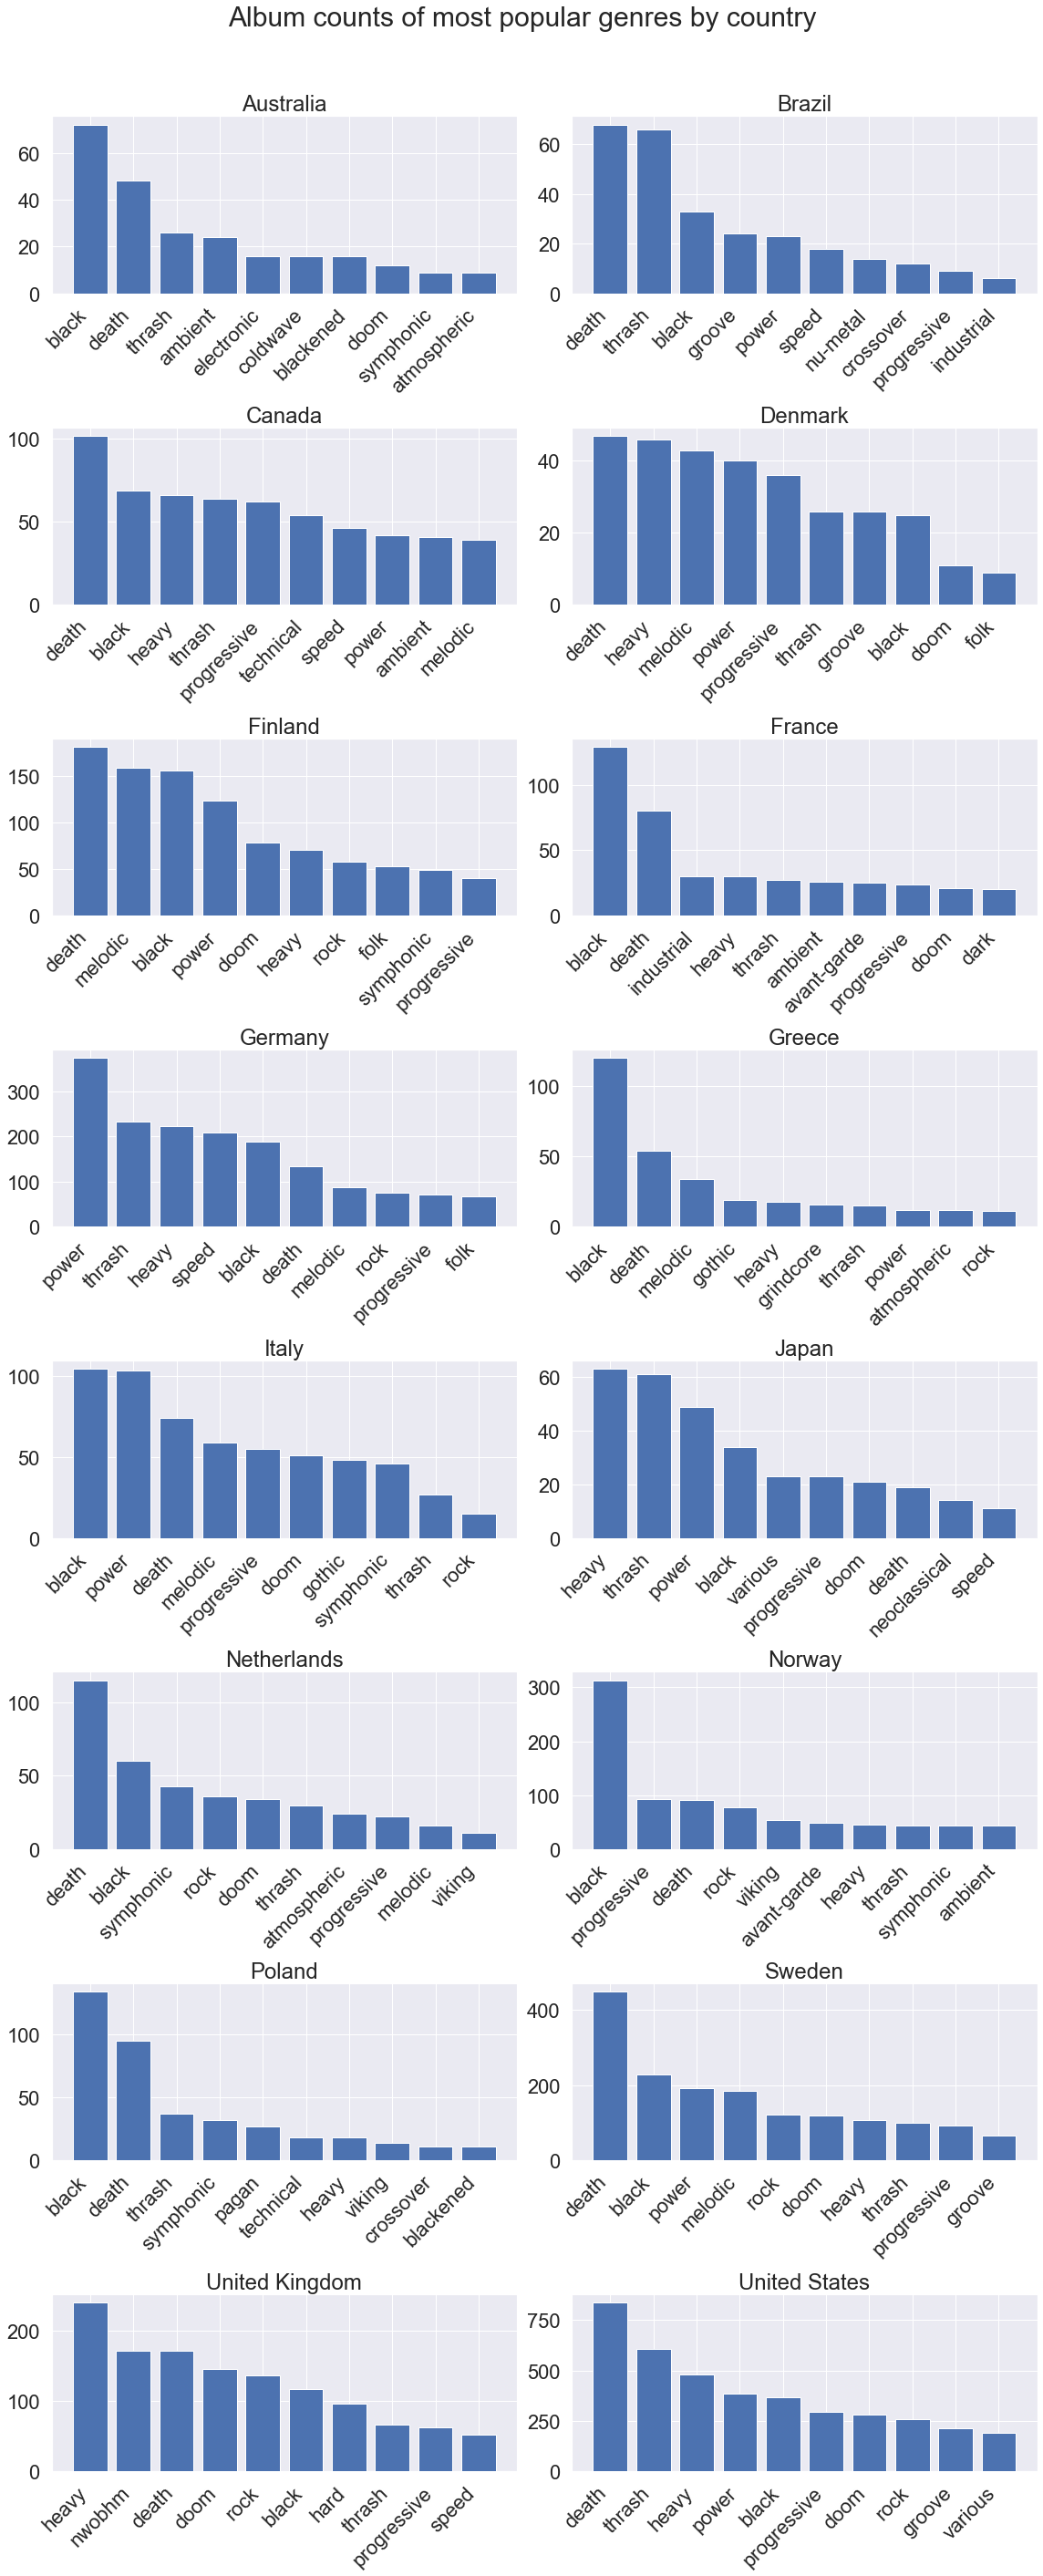

In [35]:
min_albums = 100
ncols = 2
country_albums = df_albums.groupby('band_country_of_origin').apply(len)
countries = country_albums[country_albums > min_albums].index
nrows = int(np.ceil(len(countries) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 5 * nrows))
fig.suptitle("Album counts of most popular genres by country", fontsize=30)
axes = axes.flatten()
for i, country in enumerate(countries):
    df_country = df_albums[df_albums['band_country_of_origin'] == country]
    popular_genres = []
    albums_in_genre = []
    for genre in genres:
        num_albums = df_country['genre_' + genre].sum()
        popular_genres.append(genre)
        albums_in_genre.append(num_albums)
    x, y = [
        list(k[::-1]) for k in 
        zip(
            *sorted(
                zip(popular_genres, albums_in_genre),
                key=lambda pair: pair[1]
            )
        )
    ]
    x = x[:10]
    y = y[:10]
    ax = axes[i]
    ax.bar(x, y, zorder=3)
    ax.set_title(country)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax.grid(True)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()